In [1]:
setwd('/import/DB/zhang//data')
sce1 = readRDS('OS.final.rds')

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)



In [13]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
Attaching SeuratObject



In [14]:
Idents(sce1) = 'group'

In [15]:
library(dplyr)

In [16]:
table(sce1$group)


     OS control 
  17496    2048 

In [17]:
sce1 = subset(sce1,idents = 'control')

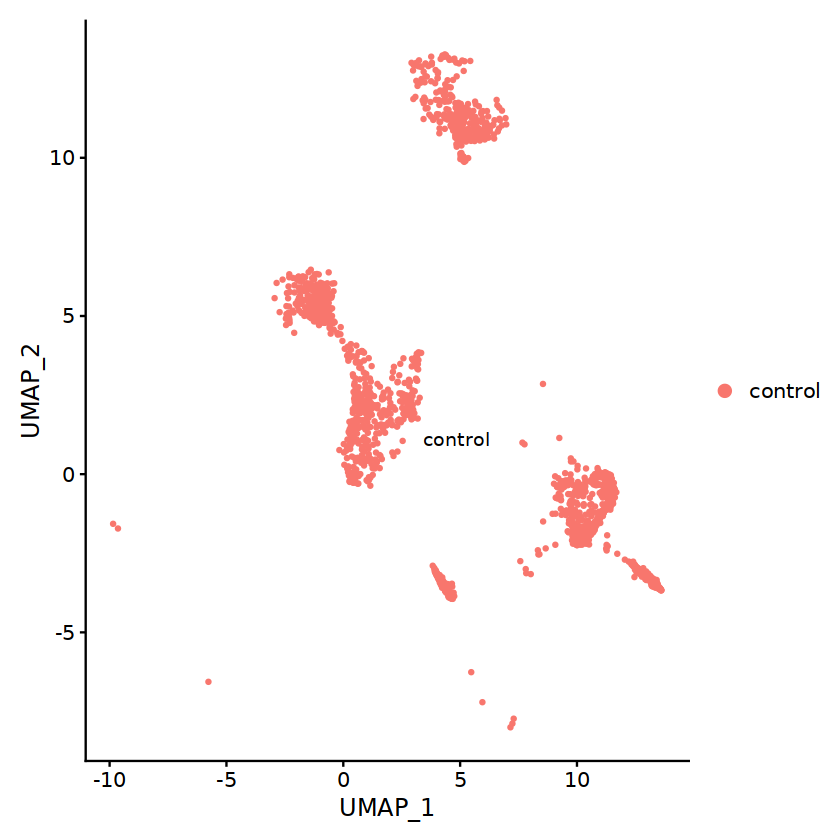

In [18]:
DimPlot(sce1,label = T)

In [19]:
library(slingshot)
library(Seurat)
library(devtools)
library(cowplot)
library(ggplot2)
library(Matrix)
library(dplyr)
library(tradeSeq)
library(RColorBrewer)
library(DelayedMatrixStats)
library(scales)
library(paletteer) 
library(viridis)

Loading required package: princurve

Loading required package: TrajectoryUtils

Loading required package: SingleCellExperiment

Warning message:
"package 'SingleCellExperiment' was built under R version 4.2.2"
Loading required package: SummarizedExperiment

Warning message:
"package 'SummarizedExperiment' was built under R version 4.2.2"
Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.2.3"

Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count



Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, col

In [20]:
sce <- as.SingleCellExperiment(sce1, assay = "RNA")

In [21]:
table(sce$celltype)


  Adipocyte        BMSC        MSCs         OBs         OS1         OS2 
        381         798         334         407           5           3 
chondrocyte 
        120 

In [22]:
sce_slingshot1 <- slingshot(sce,      #输入单细胞对象
                     reducedDim = 'UMAP',  #降维方式
                     clusterLabels = sce$celltype,  #cell类型
                     start.clus = 'BMSC',       #轨迹起点,也可以不定义
                     approx_points = 150)

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."


In [23]:
SlingshotDataSet(sce_slingshot1) 

class: SlingshotDataSet 

 Samples Dimensions
    2048          2

lineages: 3 
Lineage1: BMSC  OS1  OS2  MSCs  
Lineage2: BMSC  OS1  OS2  Adipocyte  
Lineage3: BMSC  OS1  OBs  chondrocyte  

curves: 3 
Curve1: Length: 29.23	Samples: 1347.57
Curve2: Length: 28.667	Samples: 1162.02
Curve3: Length: 26.337	Samples: 1174.17

In [24]:
cell_pal <- function(cell_vars, pal_fun,...) {
  if (is.numeric(cell_vars)) {
    pal <- pal_fun(100, ...)
    return(pal[cut(cell_vars, breaks = 100)])
  } else {
    categories <- sort(unique(cell_vars))
    pal <- setNames(pal_fun(length(categories), ...), categories)
    return(pal[cell_vars])
  }
}

### https://www.jianshu.com/p/e85d23a25a43

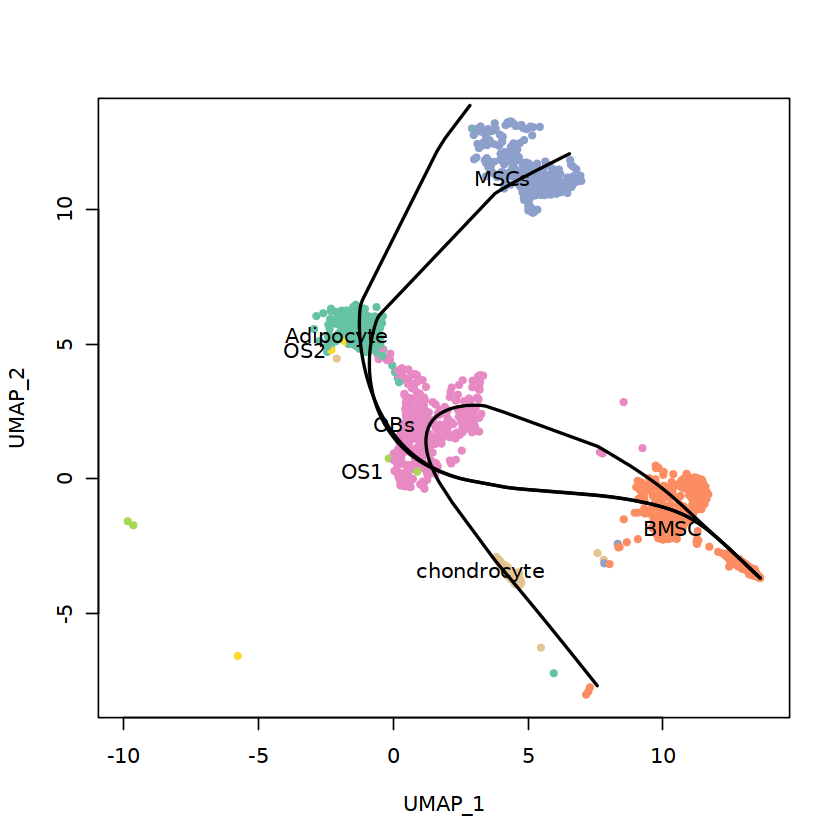

In [25]:
cell_colors <- cell_pal(sce_slingshot1$celltype, brewer_pal("qual", "Set2"))
plot(reducedDims(sce_slingshot1)$UMAP, col = cell_colors, pch=16, asp = 1, cex = 0.8)
lines(SlingshotDataSet(sce_slingshot1), lwd=2, col='black')

celltype_label <- sce1@reductions$umap@cell.embeddings%>% 
  as.data.frame() %>%
  cbind(celltype = sce1@meta.data$celltype) %>%
  group_by(celltype) %>%
  summarise(UMAP1 = median(UMAP_1),
            UMAP2 = median(UMAP_2))

for (i in 1:8) {
  text(celltype_label$celltype[i], x=celltype_label$UMAP1[i]-1, y=celltype_label$UMAP2[i])
}

In [26]:
pseudotime = slingPseudotime(sce_slingshot1)%>% as.data.frame() 
Lineages = colnames(pseudotime)

for(i in 1:3){
  pseudotime_sub <- pseudotime[,i]
  sce1 <- AddMetaData(object = sce1,
                   metadata = pseudotime_sub,
                   col.name = Lineages[i])
}

In [4]:
mouse_data = sce1

In [52]:
sce_slingshot1$sling_pseudotime = sce_slingshot1[[paste0("slingPseudotime_1")]]
mouse_data$sling_pseudotime = sce_slingshot1$sling_pseudotime

In [ ]:
#仅分析在轨迹拟时中的细胞，去除NA
sce_slingshot1_l1 = sce_slingshot1[,!is.na(sce_slingshot1$sling_pseudotime)]
seur = mouse_data[,!is.na(mouse_data$sling_pseudotime)]

#和前面一样这一步会比较慢，这个数据跑了大概1个小时。
sce_slingshot1_l1 <- fitGAM(counts(sce_slingshot1_l1), 
                            cellWeights = rep(1, ncol(sce_slingshot1_l1)), 
                            pseudotime = sce_slingshot1_l1$sling_pseudotime)

ATres <- associationTest(sce_slingshot1_l1)
association_test_tab = as_tibble(cbind(gene = rownames(ATres), ATres))

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.1 GiB"


In [ ]:
slingshot_for_plotMatrix <- function(seurat_obj,
                                     n_bins,#拟时需要分割的区间，将相似的拟时区间合并，这类似于我们monocle3中的方式
                                     min_exp)
                                     {
  seurat_meta = seurat_obj@meta.data
  seurat_meta = as_tibble(cbind(cell.id = as.character(rownames(seurat_meta)), seurat_meta))
  seurat_meta = seurat_meta[order(seurat_meta$sling_pseudotime),]
  
  pl_cells = as.character(seurat_meta$cell.id)
  
  #提取表达矩阵,并将cell id的exp排序与前面排序好的cell id一致
  exp = seurat_obj@assays$RNA@data
  exp = exp[,colnames(exp) %in% pl_cells]
  expr_mat = exp[,order(match(colnames(exp), pl_cells))]
  
  expr_mat = as.matrix(expr_mat[rownames(expr_mat) %in% association_test_tab$gene,])
  
  clust_expr_mat = matrix(nrow = nrow(expr_mat), 
                          ncol = n_bins, dimnames = list(rownames(expr_mat), 1:n_bins))
  
  max_pseudotime = max(seurat_meta$sling_pseudotime)
  pseudotime_bin_size = max_pseudotime/n_bins
  
  pseudotime_cluster_stat = NULL
  seurat_obj$pseudotime_bin = NA_integer_
  
  for (i in 1 : n_bins){
    
    bin_cells = seurat_meta$cell.id[(seurat_meta$sling_pseudotime > (i-1)*pseudotime_bin_size & 
                                       seurat_meta$sling_pseudotime <= i*pseudotime_bin_size)]

    
    seurat_obj$pseudotime_bin[colnames(seurat_obj) %in% bin_cells] = i

    #计算基因平均表达量
    if (length(bin_cells)>10){
      m2 = expr_mat[,colnames(expr_mat) %in% bin_cells]
      clust_expr_mat[,i] = apply(m2, 1, mean, na.rm = TRUE)
    }

  }
  
  #数据缩放一下，为了更好的展现热图，并删除低表达基因
  mm1 = clust_expr_mat - apply(clust_expr_mat, 1, mean, na.rm = TRUE)
  mm2 = mm1[apply(abs(mm1),1, max, na.rm = TRUE)>min_exp,]
  
  return(mm2)
  
 }


In [ ]:
mm = slingshot_for_plotMatrix(seurat_obj = seur, n_bins = 20, min_exp = 0.2)
